# Santander Customer Satisfaction Classification

From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

In this competition, you'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

Source: [Santander Customer Satisfaction](https://www.kaggle.com/competitions/santander-customer-satisfaction)

## Table of Contents
* [Required Libraries and Data](#libs)
* [Target Distribution](#target)
* [Preprocessing](#preprocessing)
    * [Removing Outliers](#rm-outliers)
    * [Feature Selection](#fs)
    * [Random Undersampling](#random-undersampling)
    * [Data Exploration](#data-exploration)
    * [Feature Engineering](#feature-engineering)
* [Modeling](#modeling)
* [Final Model](#final-model)

# <a id="libs"></a>Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    train_test_split,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)

import pickle as pkl

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

seed = 42
random.seed(seed)
np.random.seed(seed)

import os
os.environ["PYTHONWARNINGS"] = "ignore" # ignore warnings on multiprocessing units

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 9999)
pd.set_option("display.max_columns", 9999)

In [2]:
def reduce_mem_usage(df):
    numerics = df.select_dtypes(include=[int, float]).columns.to_list()
    ints = (np.iinfo(np.int8), np.iinfo(np.int16), np.iinfo(np.int32), np.iinfo(np.int64))
    floats = (np.finfo(np.float16), np.finfo(np.float32), np.finfo(np.float64), np.finfo(np.float128))

    for col in numerics:
        min_val = df[col].min()
        max_val = df[col].max()

        if "int" in df[col].dtype.name:
            for info in ints:
                if min_val >= info.min and max_val <= info.max:
                    df[col] = df[col].astype(info.dtype)
                    break
        else:
            for info in floats:
                if min_val >= info.min and max_val <= info.max:
                    df[col] = df[col].astype(info.dtype)
                    break

    return df

In [3]:
df = reduce_mem_usage(pd.read_csv("../input/santander-customer-satisfaction/train.csv"))
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [4]:
df.shape

(76020, 371)

In [5]:
df.dtypes.value_counts(ascending=False)

int8       209
float32     79
float16     32
int16       30
int64       16
int32        5
dtype: int64

In [6]:
print(f"There are {df.isnull().sum().sum()} columns with missing values.")

There are 0 columns with missing values.


In [7]:
print(f"The dataset contains {df.duplicated().sum()} duplicated rows.")

The dataset contains 0 duplicated rows.


In [8]:
nunique = df.nunique().sort_values(ascending=True)
nunique.head(50)

ind_var41                        1
num_var46                        1
imp_amort_var18_hace3            1
num_var28_0                      1
num_var28                        1
num_var27                        1
ind_var27                        1
ind_var28                        1
ind_var28_0                      1
ind_var2                         1
ind_var27_0                      1
saldo_var41                      1
num_reemb_var13_hace3            1
num_var41                        1
num_reemb_var33_hace3            1
saldo_var27                      1
saldo_var28                      1
num_trasp_var17_out_hace3        1
num_var46_0                      1
saldo_var46                      1
ind_var2_0                       1
imp_amort_var34_hace3            1
num_var27_0                      1
ind_var46_0                      1
num_var2_ult1                    1
num_var2_0_ult1                  1
ind_var46                        1
imp_reemb_var13_hace3            1
num_trasp_var33_out_

In [9]:
df.drop("ID", axis=1, inplace=True)

In [10]:
df.dtypes.value_counts()

int8       209
float32     79
float16     32
int16       30
int64       16
int32        4
dtype: int64

# <a id="target"></a>Target Distribution

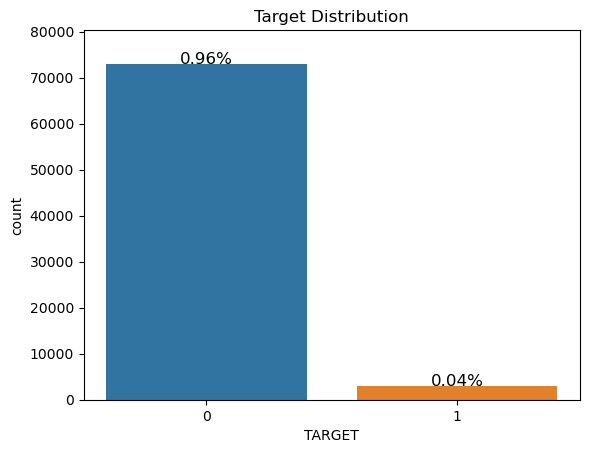

In [11]:
target_counts = df["TARGET"].value_counts().sort_index().to_frame(name="count").reset_index(names=["TARGET"])

plt.title("Target Distribution")
ax = sns.barplot(data=target_counts, x="TARGET", y="count")

for i, p in enumerate(ax.patches):
    ax.annotate(
        np.round(target_counts["count"].iloc[i] / target_counts["count"].sum(), 2).astype(str) + "%",
        ((p.get_x() + p.get_width() / 2), p.get_height() + 0.05),
        ha="center",
        size=12
    )

plt.margins(0.05, 0.1)
plt.show()

# <a id="preprocessing"></a>Preprocessing

In [12]:
X, y = df.drop(["TARGET"], axis=1), df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=seed)

### <a id="rm-outliers"></a>Removing Outliers

In [13]:
def remove_outliers(X, y, threshold=1.5):
    features = X.columns.to_list()
    outliers = []

    for feature in features:
        values = X[feature]
        Q1 = np.percentile(values, 25)
        Q3 = np.percentile(values, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - IQR * threshold
        upper_bound = Q3 + IQR * threshold
        outliers.extend(values[(values < lower_bound) | (values > upper_bound)].index.to_list())
        
    outliers = list(set(outliers))

    X.drop(outliers, axis=0, inplace=True)
    y.drop(outliers, inplace=True)
    return X, y

X_train, y_train = remove_outliers(X_train, y_train, threshold=3.0)

### <a id="fs"></a>Feature Selection

In [14]:
constant_features = DropConstantFeatures(tol=0.999, missing_values="raise")
constant_features.fit(X_train, y_train)
print(f"{len(constant_features.features_to_drop_)} of constant features to be dropped")
X_selected = constant_features.transform(X_train)

345 of constant features to be dropped


In [15]:
duplicate_features = DropDuplicateFeatures(missing_values="raise")
duplicate_features.fit(X_selected, y_train)
print(f"{len(duplicate_features.features_to_drop_)} of duplicated features to be dropped")
X_selected = duplicate_features.transform(X_selected)

7 of duplicated features to be dropped


In [16]:
rf = RandomForestClassifier(max_depth=3, n_estimators=100, criterion="gini", random_state=seed)
rf.fit(X_selected, y_train)
feature_importances = pd.Series(data=rf.feature_importances_, index=rf.feature_names_in_)
feature_importances.sort_values(ascending=False)

var15                       0.358732
saldo_var5                  0.122191
saldo_medio_var5_ult3       0.118004
saldo_medio_var5_ult1       0.069351
num_var5                    0.057644
num_meses_var5_ult3         0.050797
var38                       0.049665
ind_var5                    0.045537
saldo_medio_var5_hace2      0.045437
num_var45_hace3             0.026872
num_var45_ult3              0.023915
saldo_medio_var5_hace3      0.011743
num_med_var45_ult3          0.007975
num_meses_var39_vig_ult3    0.006532
num_var45_hace2             0.002705
var36                       0.002021
num_var45_ult1              0.000877
dtype: float64

In [17]:
zero_importance_features = feature_importances[feature_importances == 0].index.to_list()
zero_importance_features
X_selected.drop(zero_importance_features, axis=1, inplace=True)

In [18]:
correlated_features = DropCorrelatedFeatures(method="pearson", threshold=0.95, missing_values="raise")
correlated_features.fit(X_selected, y_train)
print(f"{len(correlated_features.features_to_drop_)} of highly correlated features to be dropped")
X_selected = correlated_features.transform(X_selected)

5 of highly correlated features to be dropped


In [19]:
selected_features = X_selected.columns.values
selected_features

array(['var15', 'ind_var5', 'saldo_var5', 'var36', 'num_med_var45_ult3',
       'num_meses_var39_vig_ult3', 'num_var45_hace2', 'num_var45_hace3',
       'num_var45_ult1', 'num_var45_ult3', 'saldo_medio_var5_hace3',
       'var38'], dtype=object)

In [20]:
X_train, X_test = X_train[selected_features], X_test[selected_features]

### <a id="random-undersampling"></a>Random Undersampling

In [21]:
df_train = pd.concat((X_train, y_train), axis=1)
df_target_0 = df_train[df_train["TARGET"] == 0].sample(500, random_state=seed)
df_target_1 = df_train[df_train["TARGET"] == 1].sample(500, random_state=seed)
df_undersample = pd.concat((df_target_0, df_target_1), axis=0)
df_undersample = df_undersample.sample(frac=1.0)

### <a id="data-exploration"></a>Data Exploration

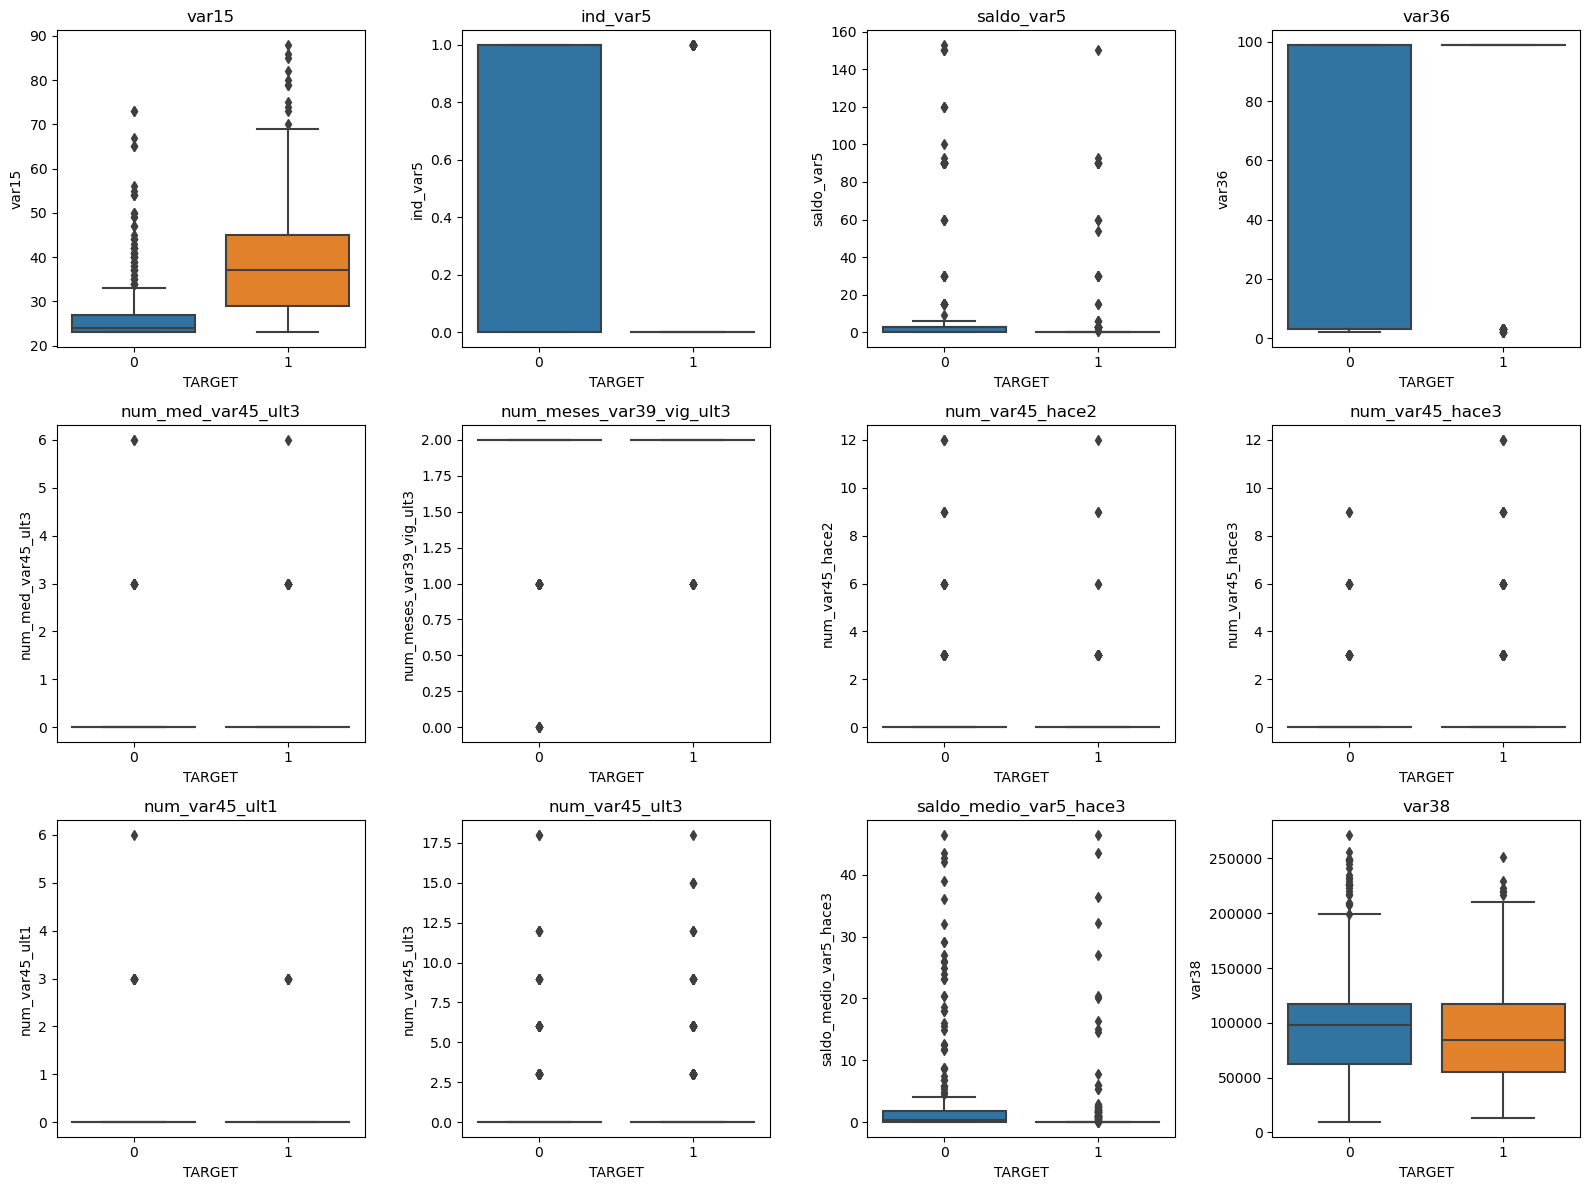

In [22]:
import math

features = df_undersample.drop("TARGET", axis=1).columns.to_list()
n_cols = 4
n_rows = math.ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.ravel()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.boxplot(data=df_undersample, x="TARGET", y=feature, ax=ax)
    ax.set_title(feature)

i += 1
while i < (n_rows * n_cols):
    axes[i].remove()
    i += 1

fig.tight_layout()
fig.show()

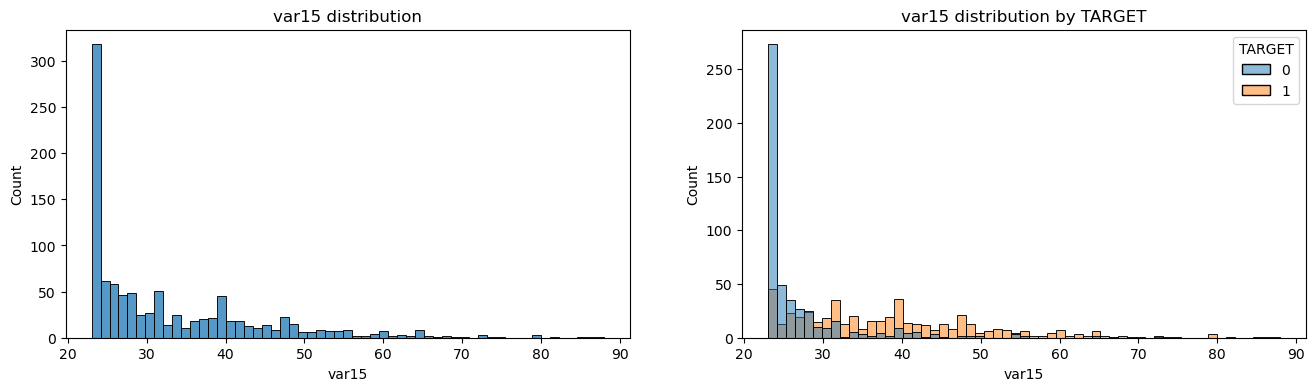

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(data=df_undersample, x="var15", bins=57, ax=ax0)
ax0.set_title("var15 distribution")

sns.histplot(data=df_undersample, x="var15", hue="TARGET", bins=57, ax=ax1)
ax1.set_title("var15 distribution by TARGET")
plt.show()

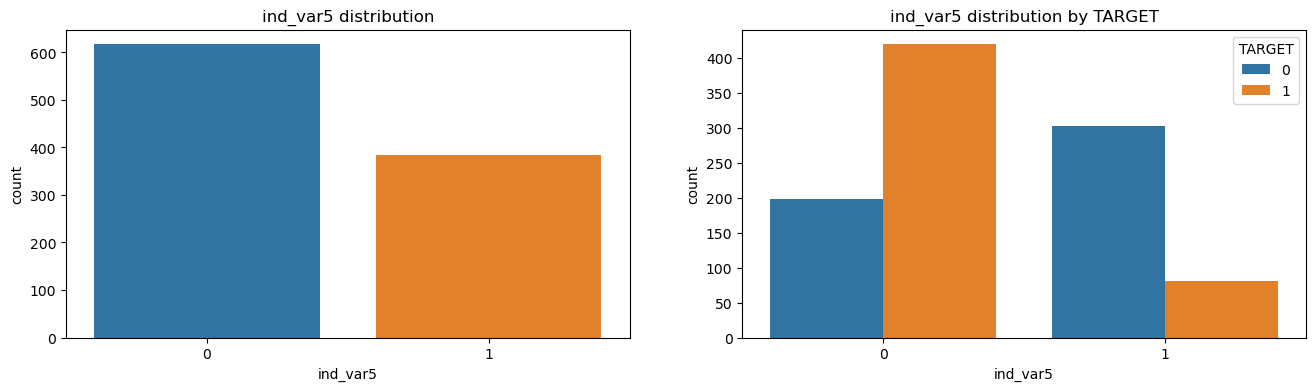

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=df_undersample, x="ind_var5", ax=ax0)
ax0.set_title("ind_var5 distribution")

sns.countplot(data=df_undersample, x="ind_var5", hue="TARGET", ax=ax1)
ax1.set_title("ind_var5 distribution by TARGET")
plt.show()

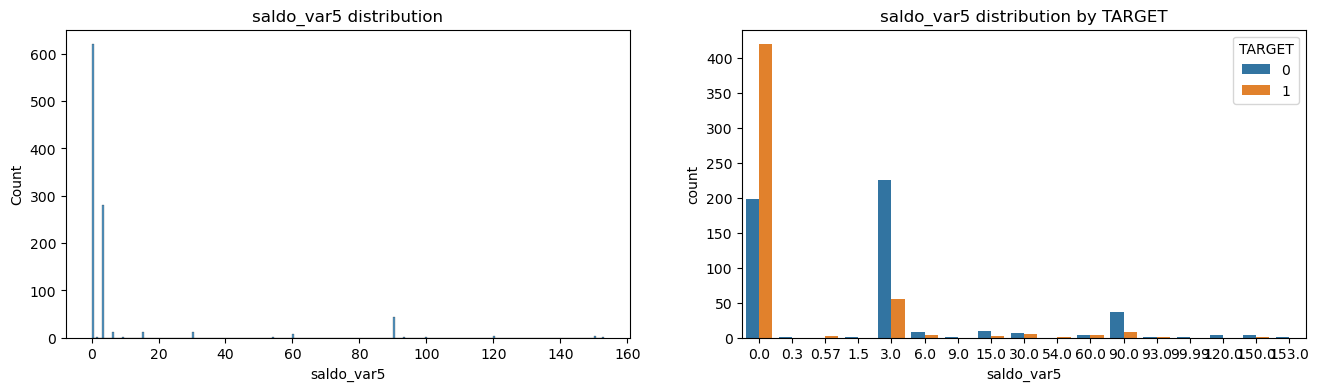

In [25]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(data=df_undersample, x="saldo_var5", ax=ax0)
ax0.set_title("saldo_var5 distribution")

sns.countplot(data=df_undersample, x=df_undersample["saldo_var5"], hue="TARGET", ax=ax1)
ax1.set_title("saldo_var5 distribution by TARGET")
plt.show()

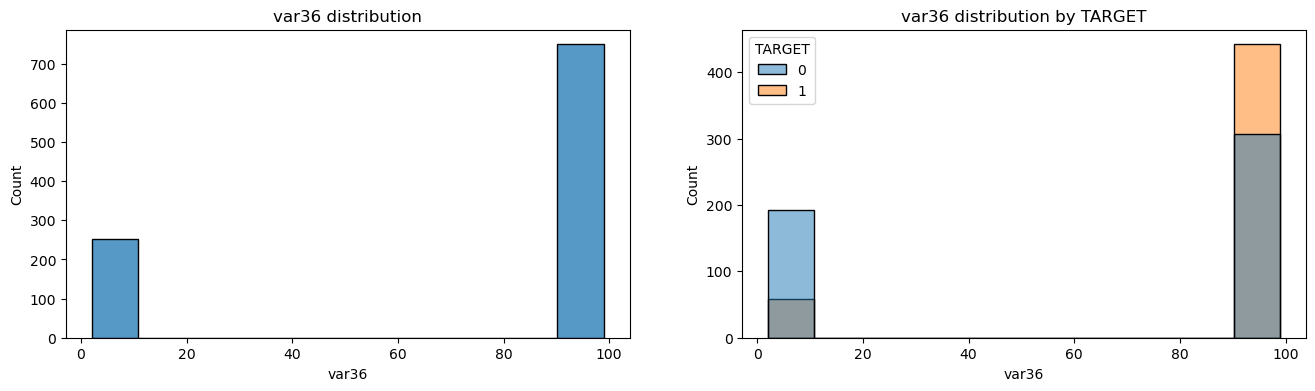

In [26]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(data=df_undersample, x="var36", ax=ax0)
ax0.set_title("var36 distribution")

sns.histplot(data=df_undersample, x="var36", hue="TARGET", ax=ax1)
ax1.set_title("var36 distribution by TARGET")
plt.show()

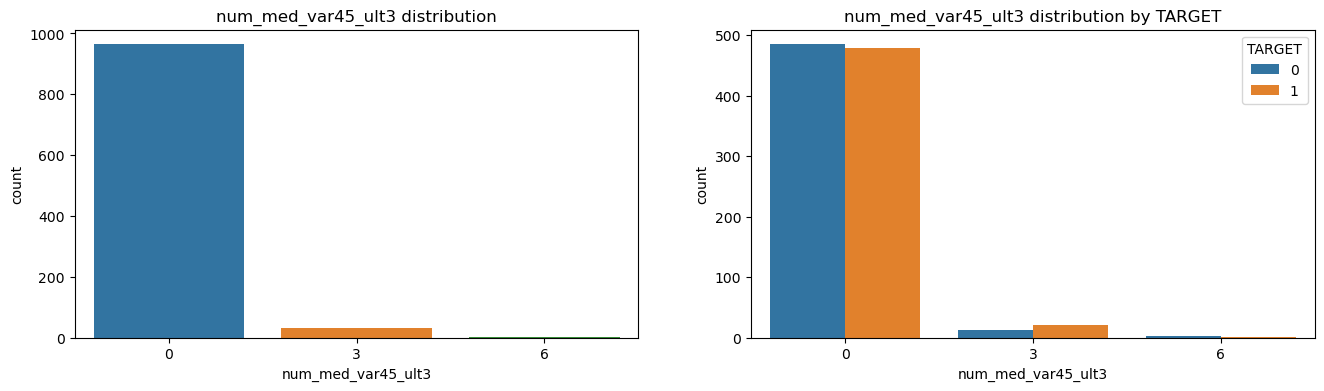

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=df_undersample, x="num_med_var45_ult3", ax=ax0)
ax0.set_title("num_med_var45_ult3 distribution")

sns.countplot(data=df_undersample, x="num_med_var45_ult3", hue="TARGET", ax=ax1)
ax1.set_title("num_med_var45_ult3 distribution by TARGET")
plt.show()

In [28]:
for f in [
    "num_med_var45_ult3",
    "num_meses_var39_vig_ult3",
    "num_var45_hace2",
    "num_var45_hace3",
    "num_var45_ult1",
    "num_var45_ult3"]:
    print(f, "\n", df_undersample[f].value_counts(normalize=True), "\n")

num_med_var45_ult3 
 0    0.964
3    0.033
6    0.003
Name: num_med_var45_ult3, dtype: float64 

num_meses_var39_vig_ult3 
 2    0.891
1    0.101
0    0.008
Name: num_meses_var39_vig_ult3, dtype: float64 

num_var45_hace2 
 0     0.923
3     0.056
6     0.011
9     0.006
12    0.004
Name: num_var45_hace2, dtype: float64 

num_var45_hace3 
 0     0.861
3     0.092
6     0.036
9     0.008
12    0.003
Name: num_var45_hace3, dtype: float64 

num_var45_ult1 
 0    0.973
3    0.026
6    0.001
Name: num_var45_ult1, dtype: float64 

num_var45_ult3 
 0     0.800
3     0.120
6     0.044
9     0.021
12    0.009
18    0.003
15    0.003
Name: num_var45_ult3, dtype: float64 



### <a id="feature-engineering"></a>Feature Engineering

In [29]:
def feature_engineering(df):
    df["var15_greater_than_23"] = (df["var15"] >= 23).astype(np.int8)
    df["var36_high"] = (df["var36"] >= 99).astype(np.int8)
    df["saldo_var5_zero"] = (df["saldo_var5"] == 0.0).astype(np.int8)
    df["num_med_var45_ult3_greater_than_zero"] = (df["num_med_var45_ult3"] > 0).astype(np.int8)
    df["var36_freq"] = df["var36"].map({99: 0.749, 3: 0.218, 2: 0.0033}).fillna(0.0).astype(np.float16)
    df["num_med_var45_ult3_freq"] = df["num_med_var45_ult3"].map({0: 0.964, 3: 0.033, 6: 0.003}).fillna(0.0).astype(np.float16)
    df["num_meses_var39_vig_ult3_freq"] = df["num_meses_var39_vig_ult3"].map({2: 0.891, 1: 0.101, 0: 0.008}).fillna(0.0).astype(np.float16)
    df["num_var45_hace2_freq"] = df["num_var45_hace2"].map({0: 0.923, 3: 0.056, 6: 0.011, 9: 0.006, 12: 0.004}).fillna(0.0).astype(np.float16)
    df["num_var45_hace2_sem"] = df["num_var45_hace2"].apply(lambda x: 1 if x <= 6 else 2)
    df["num_var45_hace3_freq"] = df["num_var45_hace3"].map({0: 0.861, 3: 0.092, 6: 0.036, 9: 0.008, 12: 0.003}).fillna(0.0).astype(np.float16)
    df["num_var45_hace3_sem"] = df["num_var45_hace3"].apply(lambda x: 1 if x <= 6 else 2)
    df["num_var45_ult1_freq"] = df["num_var45_ult1"].map({0: 0.973, 3: 0.026, 6: 0.001}).fillna(0.0).astype(np.float16)
    df["num_var45_ult3_freq"] = df["num_var45_ult3"].map({0: 0.800, 3: 0.120, 6: 0.044, 9: 0.021, 12: 0.009, 18: 0.003, 15: 0.003}).fillna(0.0).astype(np.float16)

    return df

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

# <a id="modeling"></a>Modeling

In [30]:
transformers = ColumnTransformer(transformers=[
    ("power_transformer", PowerTransformer(), [
        "var15",
        "saldo_var5",
        "num_var45_ult3",
        "saldo_medio_var5_hace3",
        "var38"
        ]
    )
])
scaler = RobustScaler()
oversampling = SMOTE(random_state=seed)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
scoring = "f1"

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=seed),
    "DT": DecisionTreeClassifier(random_state=seed),
    "SVM": SVC(max_iter=1000, random_state=seed),
    "Naive Bayes": GaussianNB(),
    "RF": RandomForestClassifier(random_state=seed),
    "XGBoost": XGBClassifier(seed=seed),
    "LightGBM": LGBMClassifier(random_state=seed)
}

score_results = []
for model in models.values():
    pipe = ImbPipeline(steps=[
        ("oversampling", oversampling),
        ("transformers", transformers),
        ("scaler", scaler),
        ("clf", model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, scoring=scoring, n_jobs=-1)
    score_results.append(scores)
    
scores_df = pd.DataFrame(score_results, columns=[i for i in range(1, 6)])
scores_df["Model"] = list(models.keys())
scores_df = pd.melt(frame=scores_df, id_vars=["Model"], value_vars=[i for i in range(1, 6)], var_name="Fold", value_name="Score").sort_values(["Model", "Fold"], ascending=True)

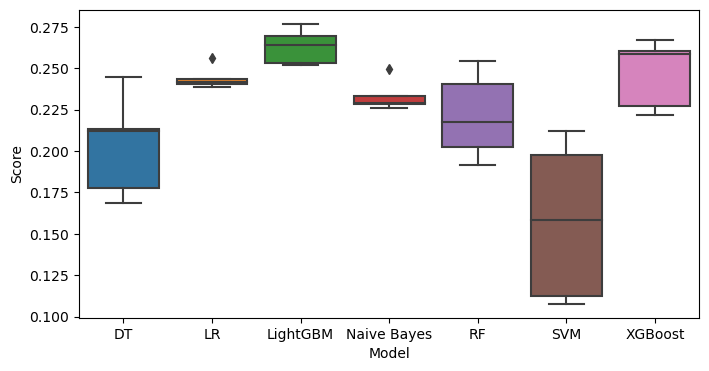

In [31]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=scores_df, x="Model", y="Score")
plt.show()

In [32]:
scores_df.groupby("Model")["Score"].agg(["mean", "std"]).sort_values(["mean", "std"], ascending=[False, True])

,mean,std
Model,,
LightGBM,0.263049,0.010756
XGBoost,0.247051,0.020840
LR,0.244155,0.007069
Naive Bayes,0.233109,0.009526
RF,0.221277,0.026097
DT,0.203283,0.030814
SVM,0.157650,0.047676


In [ ]:
pipe = ImbPipeline(steps=[
    ("oversampling", oversampling),
    ("transformers", transformers),
    ("scaler", scaler),
    ("clf", LGBMClassifier(random_state=seed))
])

search = RandomizedSearchCV(
    pipe,
    param_distributions={
        "oversampling__k_neighbors": np.arange(3, 100),
        "oversampling__sampling_strategy": ["auto"] + list(np.arange(0.4, 1.1, 0.1)),
        "clf__n_estimators": np.arange(100, 1100, 100),
        "clf__max_depth": np.arange(2, 10),
        "clf__learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9],
        "clf__colsample_bytree": np.arange(0.5, 1.1, 0.1),
        "clf__subsample": np.arange(0.5, 1.1, 0.1)
    },
    cv=cv,
    scoring=scoring,
    n_iter=500,
    n_jobs=-1
)

search = search.fit(X_train, y_train)

In [34]:
search.best_estimator_

Pipeline(steps=[('oversampling',
                 SMOTE(k_neighbors=17, random_state=42, sampling_strategy=0.5)),
                ('transformers',
                 ColumnTransformer(transformers=[('power_transformer',
                                                  PowerTransformer(),
                                                  ['var15', 'saldo_var5',
                                                   'num_var45_ult3',
                                                   'saldo_medio_var5_hace3',
                                                   'var38'])])),
                ('scaler', RobustScaler()),
                ('clf',
                 LGBMClassifier(colsample_bytree=0.7999999999999999,
                                learning_rate=0.001, max_depth=6,
                                n_estimators=900, random_state=42,
                                subsample=0.7))])

In [35]:
model = clone(search.best_estimator_)
train_preds = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)

model.fit(X_train, y_train)
test_preds = model.predict(X_test)

def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)

    return accuracy, precision, recall, f1, roc

metrics_df = pd.DataFrame(columns=["Train", "Test"], index=[
    "Accuracy",
    "Precision",
    "Recall",
    "F1-Score",
    "ROC AUC"
])

metrics_df["Train"] = metrics(y_train, train_preds)
metrics_df["Test"] = metrics(y_test, test_preds)
metrics_df

,Train,Test
Accuracy,0.904352,0.848757
Precision,0.213582,0.127795
Recall,0.517241,0.484622
F1-Score,0.302326,0.202255
ROC AUC,0.718875,0.674189


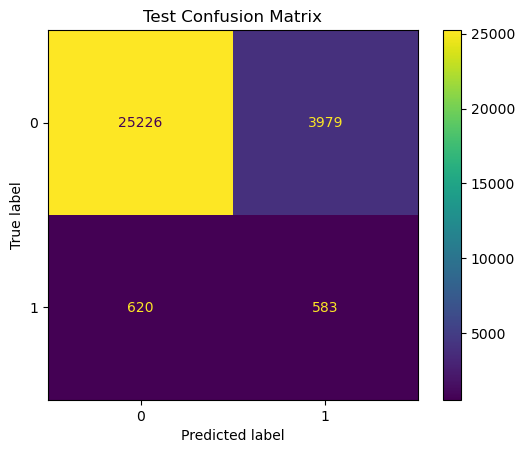

In [36]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Test Confusion Matrix")
plt.show()

# <a id="final-model"></a>Final Model

In [37]:
final_model = clone(model).fit(X_train, y_train)
with open("model.pkl", "wb") as file:
    pkl.dump(final_model, file)